In [2]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from astropy.stats import RipleysKEstimator

In [3]:
import numpy as np
from scipy.special import erfi
from _utils import rotation_matrix
from _descriptive_stats import orientation_matrix
from numba import njit
from scipy.optimize import brentq

class Watson:
    r"""
    Watson distribution
    .. note::
        The Watson distribution is only implemented for positive concentration parameter :math:`\kappa`.
    
    Args:
        mu (optional, ndarray (3, ) ): Mean axis 
        kappa (optional, float): positive concentration parameter
    The Watson distribution is an isotropic distribution for 
    axial data. Its PDF is defined as 
    .. math::
        p_{Watson}(\pm\mathbf{x}| \boldsymbol{\mu}, \kappa) & = M\left(\frac{1}{2},\frac{3}{2},\kappa\right)\exp(\kappa (\boldsymbol{\mu}^T\mathbf{x})^2) \\            
                                                            & = \frac{\sqrt{\pi}\mathrm{erfi}(\sqrt{\kappa})}{2\sqrt{\kappa}}\exp(\kappa (\boldsymbol{\mu}^T\mathbf{x})^2)
    where :math:`M` denotes `Kummer's confluent hypergeometric function <https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.hyp1f1.html#scipy.special.hyp1f1>`_ 
    and :math:`\mathrm{erfi}` the `imaginary error function <https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.erfi.html>`_ .
    References:
    Mardia, Jupp. Directional Statistics, 1999. 
    Chen. Generate Random Samples from von Mises-Fisher and Watson Distributions. 2012
    """
    def __init__(self, mu = None, kappa = None):
        
        self.mu = mu
        self.kappa = kappa

    def rvs(self, size = 1):
        '''
        Generate samples from the Watson distribution
        Arguments
        ----------
        size : int, optional, default 1
            Number of samples
        Returns
        ----------
        samples : ndarray (size, 3)
            samples as ndarray of shape (size, 3)
        ''' 
        if self.mu is not None and self.kappa is not None:
            
            sqrt_kappa = np.sqrt(self.kappa)
            constant = np.sqrt(np.pi)*erfi(sqrt_kappa)/(2*sqrt_kappa)
            z = np.array([0., 0., 1.])
            rot_matrix = rotation_matrix(z, self.mu)

            samples = _sample(self.kappa, constant, rot_matrix, size)

            return samples

        else:

            raise ValueError("Watson distribution not parameterized. Fit it to data or set parameters manually.")

    
    def pdf(self, x):
        '''
        Calculate probability density function of a set of vectors ``x`` given a parameterized 
        Watson distribution
        Arguments
        ----------
        x : ndarray (size, 3)
            Vectors to evaluate the PDF at
        Returns
        ----------
        pdfvals : ndarray (size,)
            PDF values as ndarray of shape (size, )
        '''
        if self.mu is not None and self.kappa is not None:
            
            sqrt_kappa = np.sqrt(self.kappa)
            constant = np.sqrt(np.pi)*erfi(sqrt_kappa)/(2*sqrt_kappa)
            pdf = _pdf_wo_constant(self.mu, self.kappa, x)

            pdf = pdf * constant
            return pdf

        else:

            raise ValueError("Watson distribution not parameterized. Fit it to data or set parameters manually.")
    

    def fit(self, data):
        '''
        Fits the Watson distribution to data
        Arguments
        ----------
        data : ndarray (n, 3)
            Vector data the distribution is fitted to
        '''

        T = 1/data.shape[0] * orientation_matrix(data)
        evals, evectors = np.linalg.eigh(T)
        mu_fitted = evectors[:, 2]
        
        intermed_res = np.sum(mu_fitted * (T@mu_fitted))

        def obj(kappa):

            sqrt_kappa = np.sqrt(kappa)
            nominator = (2*np.exp(kappa)*sqrt_kappa - np.sqrt(np.pi) * erfi(sqrt_kappa))/(4*kappa**1.5)
            denominator = np.sqrt(np.pi)*erfi(sqrt_kappa)/(2*sqrt_kappa)

            f = nominator/denominator - intermed_res

            return f

        kappa_fit, root_res = brentq(obj, 1e-4, 500., full_output=True)
        
        if root_res.converged == True:
            self.mu = mu_fitted
            self.kappa = kappa_fit

        else:
            raise ValueError("Concentration parameter could not be estimated.")

@njit(cache = True)
def _pdf_wo_constant(mu, kappa, x):

    n_samples, _ = x.shape
    unnormalized_pdf = np.zeros((n_samples, ))

    for i in range(n_samples):

        unnormalized_pdf[i] = np.exp(kappa * ((x[i, :] * mu).sum())**2)

    return unnormalized_pdf

@njit(cache = True)
def rejection_sampling_numba(kappa, constant, size):

    res_array = np.zeros((size, ))

    #maximal density for given kappa
    maxy = constant * np.exp(kappa)

    number_samples = 0

    while number_samples < size:

        #draw uniform samples 
        x_rand = np.random.uniform(-1.0, 1.0)
        y_rand = np.random.uniform(0.0, maxy)

        #calculate density at position x
        f = constant * np.exp(kappa * x_rand * x_rand)

        #accept or reject
        if y_rand < f:

            res_array[number_samples] = x_rand
            number_samples +=1
    
    return res_array

@njit(cache = True)
def _sample(kappa, constant, rot_matrix, size):

    ones = np.ones((size, ))

    z = rejection_sampling_numba(kappa, constant, size)

    temp = np.sqrt(ones - np.square(z))
    uniformcirle = 2 * np.pi * np.random.random(size)
    x = np.cos(uniformcirle)
    y = np.sin(uniformcirle)

    samples = np.empty((size, 3))

    samples[:, 0] = temp * x
    samples[:, 1] = temp * y
    samples[:, 2] = z

    for i in range(size):

        vec=samples[i, :]
        
        samples[i, :] = rot_matrix.dot(vec)

    return samples

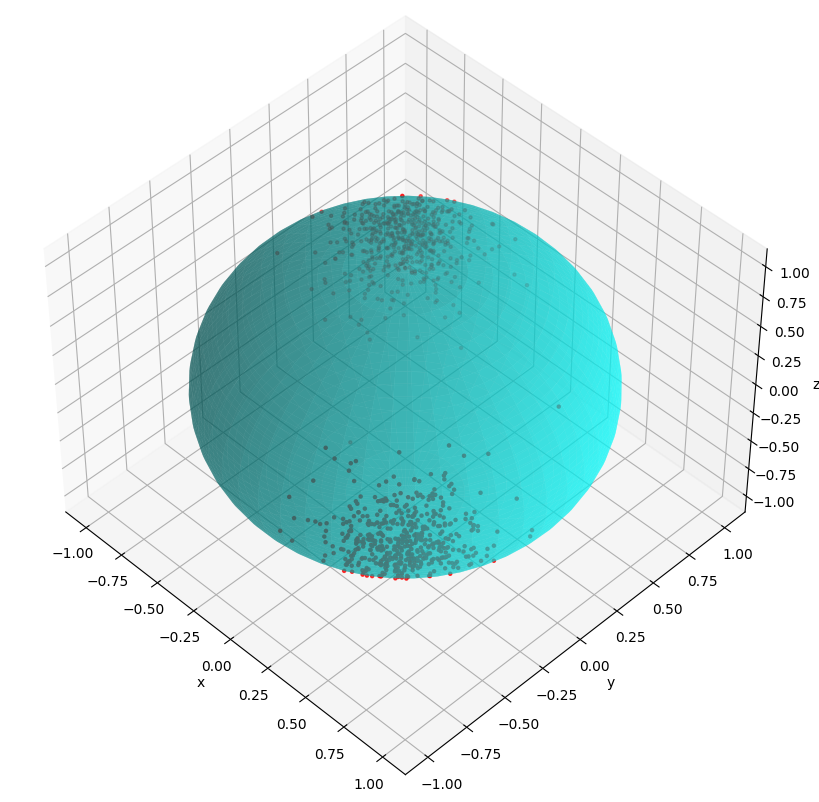

In [8]:
from _plot_utils import sphere

mu = np.array([1, -1, 0])
kappa = 10

watson = Watson(mu, kappa)

samples = watson.rvs(1000)
samples = samples / np.linalg.norm(samples, axis = 1)[:, None]

#plotting the samples

N_GRID = 50

x, y, z = sphere(n_grid = N_GRID)
plt.rcParams['figure.figsize'] = [10, 10]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x, y, z,  rstride=1, cstride=1, color='cyan', alpha=0.5, linewidth=1)

ax.scatter(samples[:, 0], samples[:, 1], samples[:, 2], c = 'r' ,s=5)
ax.view_init(45, -45)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

Text(0, 0.5, 'y')

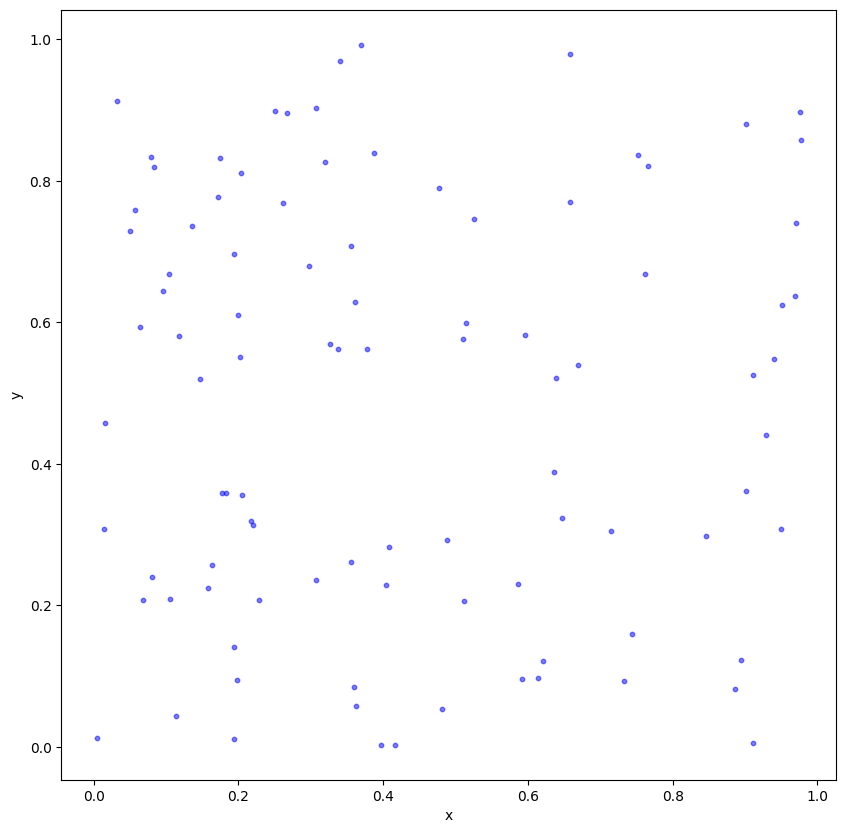

In [5]:
#Simulation window parameters
xMin=0;xMax=1;
yMin=0;yMax=1;
xDelta=xMax-xMin;yDelta=yMax-yMin; #rectangle dimensions
areaTotal=xDelta*yDelta;
 
#Point process parameters
lambda0=100; #intensity (ie mean density) of the Poisson process
 
#Simulate Poisson point process
numbPoints = scipy.stats.poisson( lambda0*areaTotal ).rvs()#Poisson number of points
xx = xDelta*scipy.stats.uniform.rvs(0,1,((numbPoints,1)))+xMin#x coordinates of Poisson points
yy = yDelta*scipy.stats.uniform.rvs(0,1,((numbPoints,1)))+yMin#y coordinates of Poisson points
#Plotting
plt.scatter(xx,yy, s=10, edgecolor='b', facecolor='b', alpha=0.5 )
plt.xlabel("x"); plt.ylabel("y")

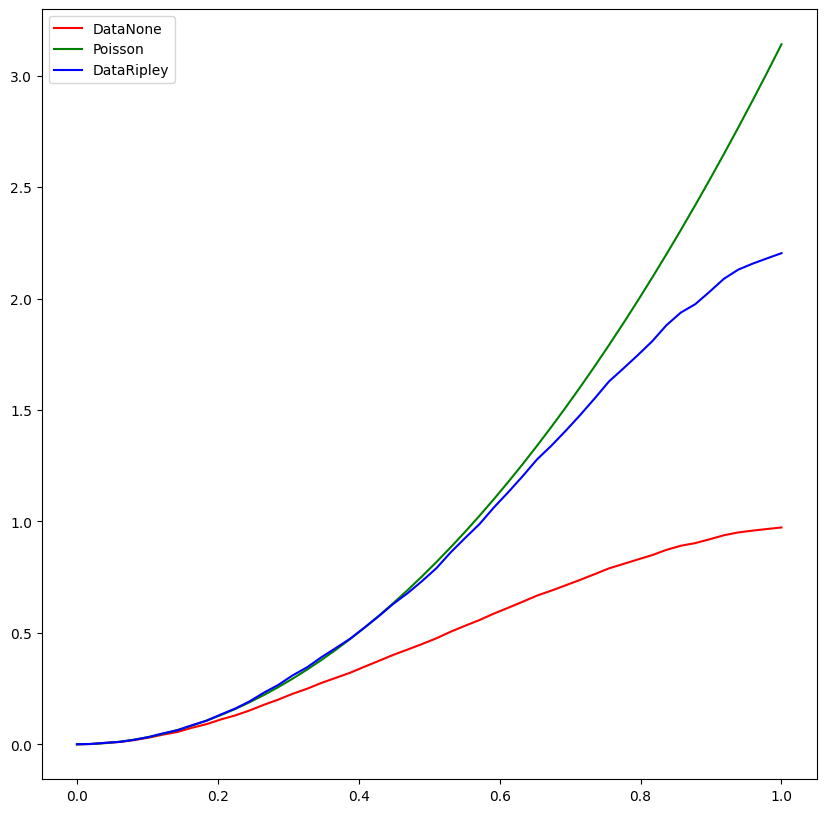

In [6]:
data = list(zip(xx[:,0], yy[:,0]))
r = np.linspace(0, 1, 50)

# total distance between all points n * (n-1) / 2
Kest = RipleysKEstimator(area=1, x_max=1, y_max=1, x_min=0, y_min=0)

plt.plot(r, Kest(data=data, radii=r, mode='none'), color='red', label='DataNone') #without correction
plt.plot(r, Kest.poisson(r), color='green', label='Poisson')
plt.plot(r, Kest(data=data, radii=r, mode='ripley'), color='blue', label='DataRipley')
plt.legend()
plt.show()

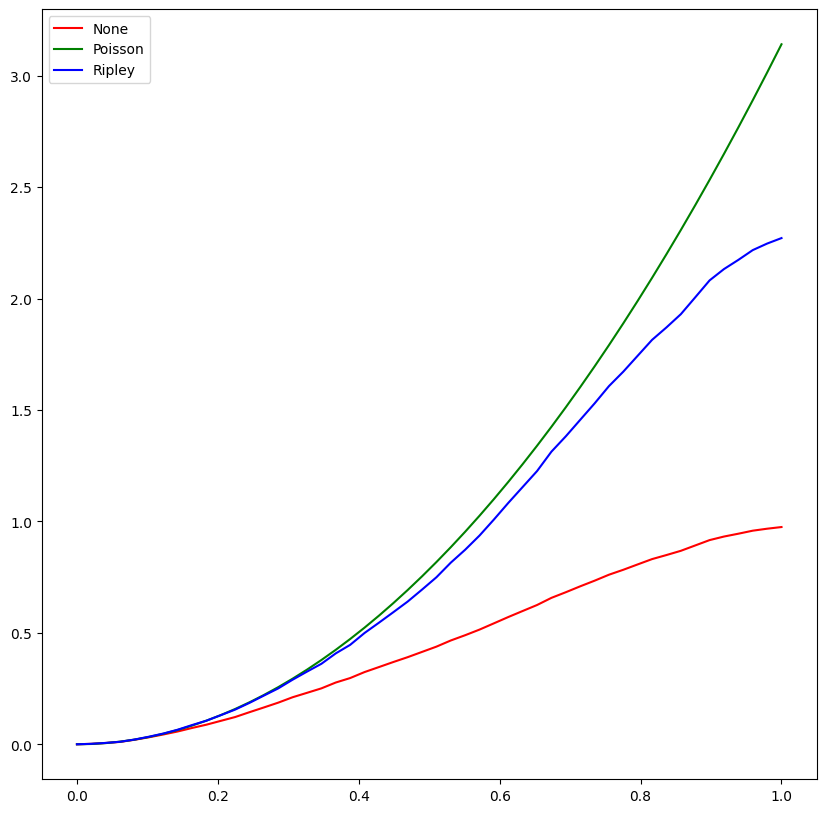

In [7]:
rng = np.random.default_rng()
data2 = rng.random((100, 2))
plt.plot(r, Kest(data=data2, radii=r, mode='none'), color='red', label='None')
plt.plot(r, Kest.poisson(r), color='green', label='Poisson')
plt.plot(r, Kest(data=data2, radii=r, mode='ripley'), color='blue', label='Ripley')
plt.legend()
plt.show()